# Project 1: Articles/Posts Topic Classifier

### IMPORTS

In [41]:
import json # for data
import pandas as pd # for data 
import numpy as np # for data

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

import re # preprocessing
import nltk # preprocessing
from nltk.corpus import stopwords # preprocessing
import nltk # preprocessing
nltk.download('wordnet') # preprocessing
import nltk # preprocessing
nltk.download('omw-1.4') # preprocessing
nltk.download('stopwords') # preprocessing

from sklearn import model_selection # for model

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Abdelhadi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Abdelhadi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abdelhadi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
dict = []
with open('data.json', mode = 'r', errors = 'ignore') as json_file:
    for dic in json_file:
        dict.append( json.loads(dic) )
## print the first one
dict[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [50]:
## create dtf
dataSet = pd.DataFrame(dict)
## filter categories
dataSet = dataSet[ dataSet["category"].isin(['BUSINESS','POLITICS','SPORTS']) ][["category","headline"]]
## print 5 random rows
dataSet.sample(5)

,category,headline
21479,POLITICS,Senate Intelligence Committee To Investigate W...
23187,POLITICS,Republicans Keep Trying To Shut Women Down
22920,POLITICS,"News Roundup for June 27, 2017"
64464,POLITICS,DNC Chair Debbie Wasserman Schultz Is Taking A...
44640,POLITICS,Donald Trump’s Top Staff Make Big Bucks But Do...


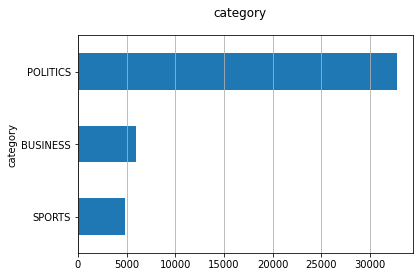

In [52]:
fig, ax = plt.subplots()
fig.suptitle("category", fontsize=12)
dataSet["category"].reset_index().groupby("category").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [53]:
def processText(text):
    ## removing the special characters (\r & \n) and punctuations, convert to lowercase, and strip  
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower().replace('\n',' ').replace('\r','').strip()
            
    ## Tokenize (convert from string to list)
    wordTokens = text.split()
    
    ## remove Stopwords
    stopWords = set(stopwords.words('english')) 
    filteredSentence = [w for w in wordTokens if not w in stopWords] 
    filteredSentence = [] 
    for w in wordTokens: 
        if w not in stopWords: 
            filteredSentence.append(w) 
                
    ## Stemming (remove -ing, -ly, ...)
    ps = nltk.stem.porter.PorterStemmer()
    filteredSentence = [ps.stem(word) for word in filteredSentence]
                
    ## Lemmatisation (convert the word into root word)
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    filteredSentence = [lem.lemmatize(word) for word in filteredSentence]
            
    ## back to string from list
    text = " ".join(filteredSentence)
    return text

In [46]:
stopWords = nltk.corpus.stopwords.words("english")

In [47]:
dataSet["headline_clean"] = dtf["headline"].apply(lambda x: process_text(x))
dtf.head()

,category,headline,headline_clean
13,POLITICS,Trump's Crackdown On Immigrant Parents Puts Mo...,trump crackdown immigr parent put kid alreadi ...
14,POLITICS,'Trump's Son Should Be Concerned': FBI Obtaine...,trump son concern fbi obtain wiretap putin all...
15,POLITICS,Edward Snowden: There's No One Trump Loves Mor...,edward snowden there one trump love vladimir p...
16,POLITICS,Booyah: Obama Photographer Hilariously Trolls ...,booyah obama photograph hilari troll trump spi...
17,POLITICS,Ireland Votes To Repeal Abortion Amendment In ...,ireland vote repeal abort amend landslid refer...


In [48]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size = 0.2)
## get target
y_train = dtf_train["category"].values
y_test = dtf_test["category"].values